Before actually doing outlier runs, ensure you have a working version of `discovery`, `numpyro`, and `jax`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, re
import discovery as ds
from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
import sys
from loguru import logger
import jax.scipy.linalg as jsl
import json
from discovery import selection_backend_flags, matrix
#import outlier_utils as ou

In [3]:
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

In [4]:
import pint_pal.lite_utils as lu
import pint_pal.noise_utils as nu
import pint_pal.plot_utils as pu
# from pint_pal.par_checker import *
from pint_pal import utils
from pint_pal.dmx_utils import setup_dmx, model_dmx_params, apply_frequency_ratio_cuts
from pint_pal.timingconfiguration import TimingConfiguration
from pint_pal.utils import apply_cut_flag, apply_cut_select
from pint_pal.plot_utils import plot_residuals_time 
from pint_pal import outlier_utils as ou
from enterprise.pulsar import Pulsar as ePulsar
import yaml
from astropy import log
import pint.fitter
from pint.utils import dmxparse

In [5]:
log.setLevel("WARNING") # Set desired verbosity of log statements (DEBUG/INFO/WARNING/ERROR)
log_to_file = False

lu.git_config_info()

/bin/sh: git: command not found
/bin/sh: git: command not found


In [54]:
# Notebook run settings
autorun = False
analyze_postfit = True # was originally false jgb
run_outlier_analysis = True # was originally false jgb
use_outlier_results = True
epochdrop_threads = 20
if autorun:
    run_outlier_analysis = True
    use_outlier_results = False
    
# Load tim file with pout values already assigned (i.e. if restarting outlier analyses midway through)
load_pout = None
load_pout = '/home/baierj/src/pint_pal/nb_templates/outlier/J0709+0458.nb/J0709+0458.nb_pout.tim'

In [ ]:
config = "configs/[psr_name].[nb or wb].yaml"  # fill in actual path
par_directory = None   # default location
tim_directory = None   # default location
tc = TimingConfiguration(config, par_directory=par_directory, tim_directory=tim_directory)
using_wideband = tc.get_toa_type() == 'WB'

# For manual inspection:
file_matches, toa_matches = tc.get_investigation_files()

## the below is a testing cell. to be removed for the template notebook -- jgb

In [8]:
## testing cell -- jgb
psr_name = 'J0709+0458'
ng20_dir = "/shared/hazgrav/data/nanograv/20yr/ng20"
config = f"{ng20_dir}/configs/{psr_name}.nb.yaml"  # fill in actual path
par_directory = ng20_dir+'/results/'   # default location
tim_directory = ng20_dir+'/toas/'   # default location
tc = TimingConfiguration(config, par_directory=par_directory, tim_directory=tim_directory)
using_wideband = tc.get_toa_type() == 'WB'

# For manual inspection:
file_matches, toa_matches = tc.get_investigation_files()

In [9]:
# Use excise.tim file if it exists, else revert to raw TOAs & initial cuts
use_toa_pickle = False
mo,to = tc.get_model_and_toas(excised=True,usepickle=use_toa_pickle)
if not to: mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
tc.manual_cuts(to)
#to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())
to

2025-08-25 15:57:15.902 | INFO     | pint.toa:get_TOAs:239 - Reading TOAs from the picklefile for `['/shared/hazgrav/data/nanograv/20yr/ng20/toas/J0709+0458.L-wide.PUPPI.15y.x.nb.tim', '/shared/hazgrav/data/nanograv/20yr/ng20/toas/J0709+0458.S-wide.PUPPI.15y.x.nb.tim']`


3133 TOAs starting at MJD 57389.2116850149

In [10]:
dmx_ranges, dmx_vals, dmx_errs = model_dmx_params(mo)
to = apply_frequency_ratio_cuts(to, dmx_ranges, frequency_ratio=1.1, quiet=False)
to

3132 TOAs starting at MJD 57389.2116850149

In [11]:
wndict = json.load(open(f"{ng20_dir}/../noise_dicts/ng20_v1p1_dmx_noise_dict.json", 'r'))

In [12]:
psr = ePulsar(mo, to)

2025-08-25 15:57:26.141 | INFO     | pint.solar_system_ephemerides:load_kernel:194 - Set solar system ephemeris to de440 through astropy
2025-08-25 15:57:26.383 | DEBUG    | pint.toa:add_vel_ecl:2496 - Adding column ssb_obs_vel_ecl
2025-08-25 15:57:26.383 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 15:57:26.387 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 15:57:26.390 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 15:57:26.697 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 15:57:26.700 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 15:57:26.704 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 15:57:26.739 | DEBUG    | pint.models

## test disco outliers for one sample

In [13]:
psrl = ou.make_single_psr_model_scaled_errors(psr, tm_variable=True)

In [14]:
jcond = jax.jit(ou.make_sample_cond_with_tm(psrl))
jclogl = jax.jit(psrl.clogL)

In [15]:
pdict = ds.priordict_standard.copy()
pdict.update({f'(.*_)?alpha_scaling\\(([0-9]*)\\)': [0.999, 1.001]})
pdict.update({f'(.*_)?timingmodel_coefficients\\(([0-9]*)\\)': [0.999, 1.001]})
np.random.seed(1)
test_pars = ds.prior.sample_uniform(psrl.logL.params, priordict=pdict)

In [16]:
# key, out = psrl.sample_conditional(jax.random.key(0), test_pars)
key, out = jcond(jax.random.key(0), test_pars)
test_pars.update(out)

In [17]:
%%timeit
jclogl(test_pars)

141 μs ± 1.31 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## test disco outliers from imported functions

In [21]:
log.info('Running discovery-gibbs outlier analysis...')
log.info('Loading enterprise pulsar object...')
# should put in a checker to make sure these priors match !!
prior_dict = ou.get_discovery_prior_dictionary()

In [22]:
log.info('Setting up discovery outlier Gibbs sampler...')
sampler = ou.setup_sampler_discovery_outlier_analysis(psr, prior_dict=prior_dict)

In [23]:
log.info('Beginning to sample...')
sampler.run(jax.random.PRNGKey(0))
log.info('Sampling complete. Calculating pout for all toas.')
pout = np.mean(sampler.get_samples()['z_i'], axis=0)

sample: 100%|██████████| 120/120 [00:17<00:00,  6.82it/s, 7 steps of size 1.76e-02. acc. prob=0.98]   


In [24]:
pout

Array([0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.04], dtype=float64)

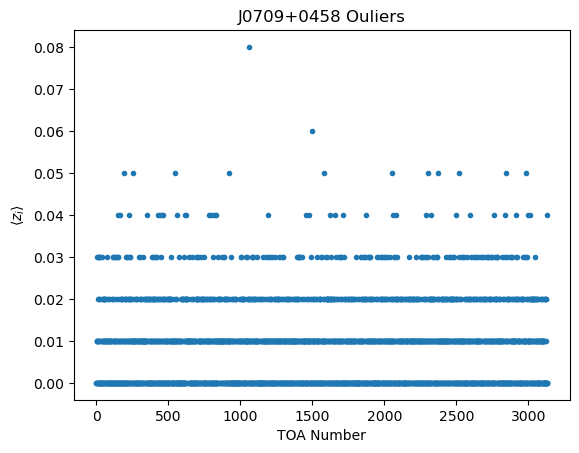

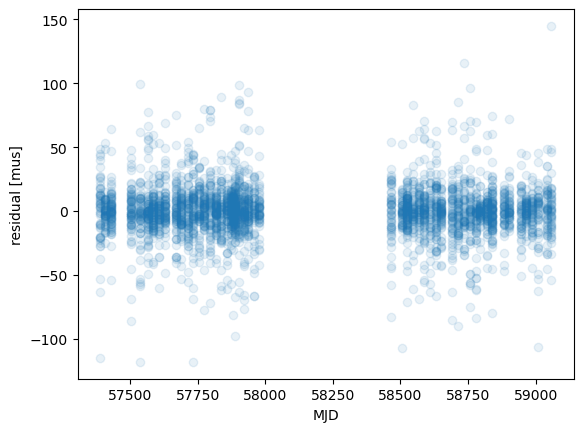

In [31]:
plt.plot(pout, marker='.', linestyle='')
plt.title(f"{psr.name} Ouliers")
plt.xlabel("TOA Number")
plt.ylabel("$\\langle z_i \\rangle$")
# plt.scatter([100, 345, 900, 1000], [1, 1, 1, 1], marker='o', facecolor='none', edgecolor='r')
# plt.yscale("log")
plt.show()
#bad_toa_mask = np.mean(samples['z_i'], axis=0) > 0.1
bad_toa_mask = pout > 0.1

plt.errorbar(psr.toas / 86400, psr.residuals/1e-6, yerr=psr.toaerrs, alpha=0.1, fmt='o')
plt.scatter(psr.toas[bad_toa_mask] / 86400, psr.residuals[bad_toa_mask]/1e-6, facecolor='none', edgecolor='r')
plt.xlabel('MJD')
plt.ylabel('residual [mus]') 
#plt.ylim(-1e-5, 1e-5)
plt.show()

## test outlier analysis integrated into Pint-pal workflow

In [32]:
tc.config['outlier']['method'] = 'discovery-gibbs'
tc.config['outlier']

{'method': 'discovery-gibbs', 'n-burn': 1000, 'n-samples': 20000}

In [33]:
tc.config

{'source': 'J0709+0458',
 'par-directory': '/shared/hazgrav/data/nanograv/20yr/ng20/results/',
 'tim-directory': '/shared/hazgrav/data/nanograv/20yr/ng20/toas/',
 'timing-model': 'J0709+0458_PINT_20250326.nb.par',
 'compare-model': 'archive/J0709+0458_PINT_20220302.nb.par',
 'toas': ['J0709+0458.L-wide.PUPPI.15y.x.nb.tim',
  'J0709+0458.S-wide.PUPPI.15y.x.nb.tim'],
 'free-params': ['ELONG',
  'ELAT',
  'PMELONG',
  'PMELAT',
  'PX',
  'F0',
  'F1',
  'A1',
  'PB',
  'T0',
  'E',
  'OM',
  'JUMP1',
  'FD1'],
 'free-dmx': True,
 'toa-type': 'NB',
 'fitter': 'Auto',
 'n-iterations': 20,
 'ephem': 'DE440',
 'bipm': 'BIPM2023',
 'dmx': {'ignore-dmx': False,
  'fratio': 1.1,
  'max-sw-delay': 0.1,
  'custom-dmx': []},
 'outlier': {'method': 'discovery-gibbs', 'n-burn': 1000, 'n-samples': 20000},
 'noise_run': {'model': {'inc_rn': True,
   'inc_dmgp': False,
   'inc_chromgp': False},
  'inference': {'likelihood': 'enterprise',
   'sampler': 'PTMCMCSampler',
   'n_iter': 250000,
   'emp_distri

In [64]:
# whether or not to run outlier analysis or load the pout values
load_pout = '/home/baierj/src/pint_pal/nb_templates/outlier/J0709+0458.nb/J0709+0458.nb_pout.tim'
load_pout = None

In [65]:
if run_outlier_analysis:
    if not load_pout: # load raw tims unless otherwise noted
        mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
        to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())
    else:
        mo,to = tc.get_model_and_toas(pout_tim_path=load_pout)
        to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())
        
    # Run outlier analysis and assign outlier probabilities to TOAs (narrowband only)
    # Skip calculate_pout if starting from pout.tim (load_pout is set)
    if not using_wideband:
        if not load_pout:
            tc.check_outlier()
            ou.calculate_pout(mo, to, tc)       
        ou.make_pout_cuts(mo, to, tc, outpct_threshold=8.0)
    ## comment out the epochalyptica for now
    #ou.epochalyptica(mo,to,tc,nproc=epochdrop_threads)

2025-08-25 16:27:35.615 | INFO     | pint.toa:get_TOAs:239 - Reading TOAs from the picklefile for `['/home/baierj/src/pint_pal/nb_templates/J0709+0458.L-wide.PUPPI.15y.x.nb.tim', '/home/baierj/src/pint_pal/nb_templates/J0709+0458.S-wide.PUPPI.15y.x.nb.tim']`
2025-08-25 16:27:40.437 | INFO     | pint.solar_system_ephemerides:load_kernel:194 - Set solar system ephemeris to de440 through astropy
2025-08-25 16:27:40.678 | DEBUG    | pint.toa:add_vel_ecl:2496 - Adding column ssb_obs_vel_ecl
2025-08-25 16:27:40.678 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:27:40.681 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:27:40.685 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:27:40.991 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:27:40.994 | DEB

In [66]:
to

3208 TOAs starting at MJD 57389.2116850149

In [68]:
use_outlier_results = False

In [69]:
tc.config['intermediate-results']['excised-tim'] = '/home/baierj/src/pint_pal/nb_templates/outlier/J0709+0458.nb/J0709+0458.nb_pout.tim'

In [70]:
if use_outlier_results:        
    mo,to = tc.get_model_and_toas(excised=True)
if (not run_outlier_analysis) and (not use_outlier_results):
    mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
    to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())

In [71]:
to

3208 TOAs starting at MJD 57389.2116850149

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


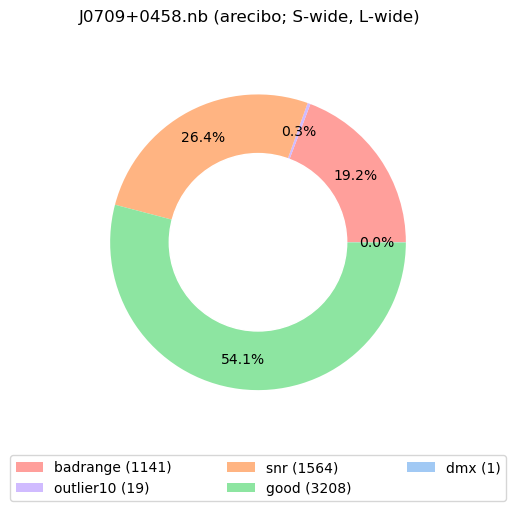

In [72]:
# Quick breakdown of existing cut flags (automated excision)
cuts_dict = lu.cut_summary(to,tc)

In [73]:
# Apply manual cuts and check for redundancies
tc.manual_cuts(to)
to = setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())

  - [puppi_58587_J0709+0458_0159.15y.x.ff,4,0]
  - [puppi_59007_J0709+0458_0100.15y.x.ff,5,0]
  - [puppi_58713_J0709+0458_0178.15y.x.ff,21,0]
  - [puppi_57977_J0709+0458_0185.15y.x.ff,45,0]
  - [puppi_58607_J0709+0458_0404.15y.x.ff,21,0]
  - [puppi_58734_J0709+0458_0009.15y.x.ff,7,0]
  - [puppi_58483_J0709+0458_1208.15y.x.ff,3,0]
  - [puppi_58483_J0709+0458_1208.15y.x.ff,4,0]
  - [puppi_58483_J0709+0458_1208.15y.x.ff,5,0]
  - [puppi_58483_J0709+0458_1208.15y.x.ff,6,0]
  - [puppi_58587_J0709+0458_0157.15y.x.ff,49,0]
  - [puppi_58691_J0709+0458_0432.15y.x.ff,20,0]
  - [puppi_59056_J0709+0458_0905.15y.x.ff,5,0]
  - [puppi_57431_J0709+0458_6064.15y.x.ff,3,0]
  - [puppi_57957_J0709+0458_0345.15y.x.ff,52,0]


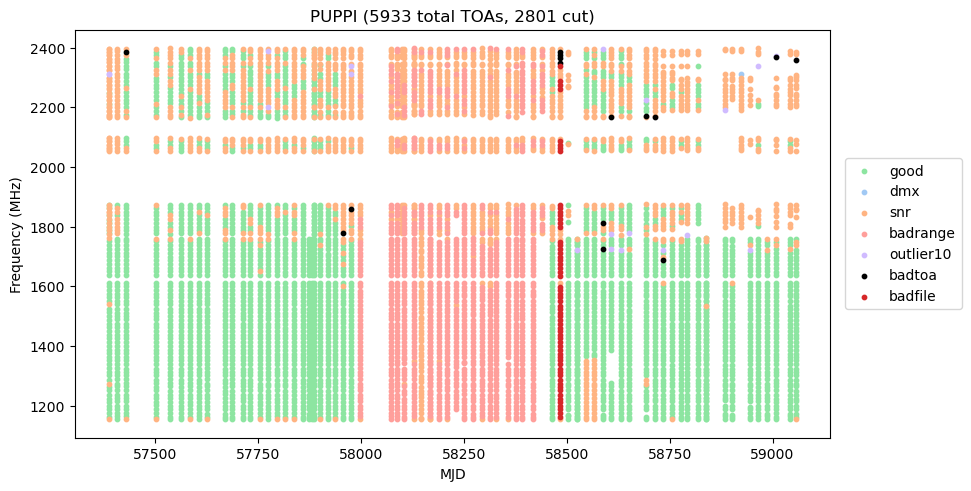

In [75]:
# More detailed breakdown of cuts by backend
lu.plot_cuts_all_backends(to, save=True)

2025-08-25 16:29:37.005 | INFO     | pint.fitter:auto:242 - For narrowband TOAs with correlated errors and downhill fitter, returning 'DownhillGLSFitter'
2025-08-25 16:29:37.310 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:37.313 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:37.317 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:37.355 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:37.418 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:37.419 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:37.421 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-0

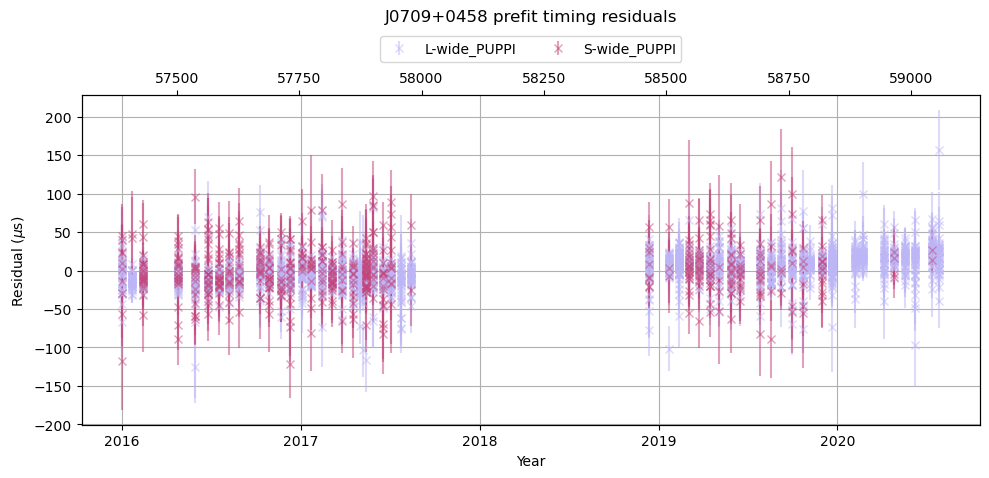

In [76]:
# Plot residuals vs. time after auto/manual cuts
fo = tc.construct_fitter(to,mo)
pu.plot_residuals_time(fo, restype='prefit')

2025-08-25 16:29:54.581 | INFO     | pint.fitter:auto:242 - For narrowband TOAs with correlated errors and downhill fitter, returning 'DownhillGLSFitter'
2025-08-25 16:29:55.094 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:55.099 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:55.104 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:55.162 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:55.227 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:55.229 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:29:55.231 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-0

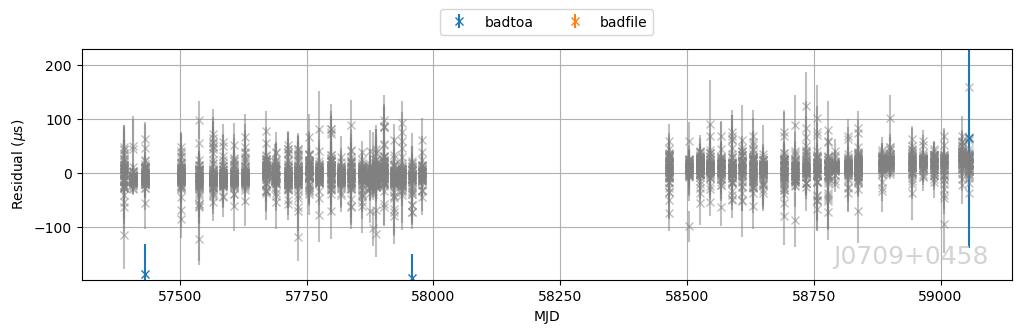

In [78]:
# Plot residuals & highlight manual cuts
lu.highlight_cut_resids(to,mo,tc,ylim_good=True)

In [79]:
# Fit if you want to analyze postfit residuals
if not autorun and analyze_postfit:
    fo.model.free_params = tc.get_free_params(fo)
    fo.fit_toas(maxiter=tc.get_niter())

2025-08-25 16:30:08.263 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:30:08.267 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:30:08.270 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:30:08.310 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2025-08-25 16:30:08.317 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:101 - Creating and dealing with the single TZR_toa for absolute phase
2025-08-25 16:30:08.319 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-08-25 16:30:08.319 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-08-25 16:30:08.320 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-25 16:3

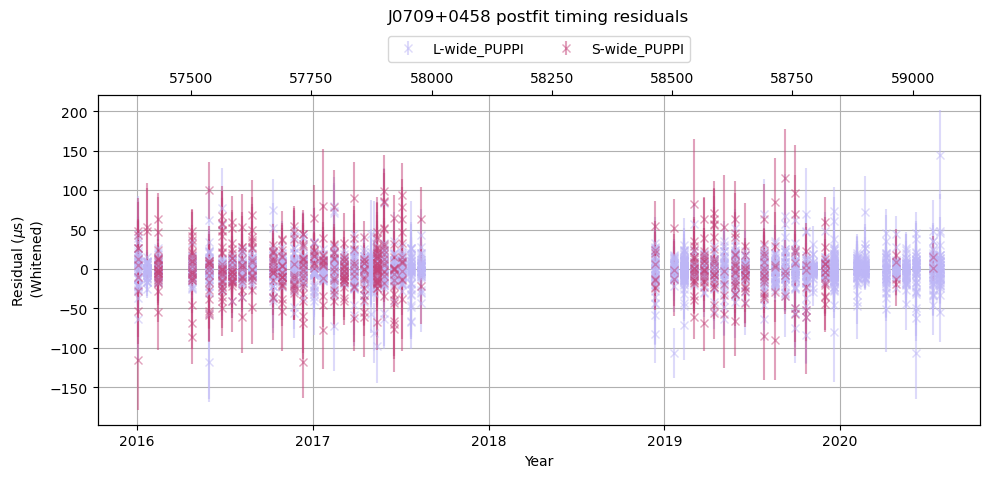

In [82]:
# Plot whitened residuals (if desired, plotsig: resid/uncertainty, avg: epoch-averaged)
if not autorun and analyze_postfit:
    plot_residuals_time(fo, restype='postfit', plotsig = False, avg = False, whitened = True)

Running display_excise_dropdowns (as below) will cause dropdowns for each bad-file and bad-toa of interest to be displayed. You should choose whatever combinations of file and plot type you'd like to make, then run the cell after this one (containing the read_excise_dropdowns functions) to read in your choices. The optional arguments all_YFp, all_GTpd, and all_profile will default the checkboxes to those plot types. If not specified, the default will be 'None' (i.e. do not plot). Finally, the make_detective_plots function (next cell) will display your plots. Note that bad_toa entries with "profile" plots selected will plot profiles for all bad subints and bad subbands of interest (as well as the integrated profile). 

In [83]:
# Display checkboxes
if not autorun:
    file_select_list, file_pav_list, toa_select_list, toa_pav_list = \
        lu.display_excise_dropdowns(file_matches, toa_matches, all_YFp=False, all_GTpd=False, all_profile=False)

As described above, this block will read your choices from the above dropdowns and make plots. Bad files and bad toas are dealt with separately to allow for future use of the bad-toa subint/subband info.

In [84]:
# Make plots (indicated by dropdown choices)
if not autorun:
    file_plot_list = lu.read_excise_dropdowns(file_select_list, file_pav_list, file_matches)
    toa_plot_list = lu.read_excise_dropdowns(toa_select_list, toa_pav_list, toa_matches)
    lu.make_detective_plots(file_plot_list, file_matches)
    lu.make_detective_plots(toa_plot_list, toa_matches)

If you'd like to look at the cal file associated with any bad-file or bad-toa entry listed in the yaml, run the following two cells. Just as above, the first cell displays the checkboxes (which show the file name, not the cal name!). Then pick your plot types, and run the cell that follows to create the plots (in this case, there isn't a separate step to read the dropdowns).

In [85]:
# Display cal file checkboxes
if not autorun: cal_select_list, full_cal_files = lu.display_cal_dropdowns(file_matches, toa_matches)

In [86]:
# Read dropdowns and make cal plots
if not autorun: lu.read_plot_cal_dropdowns(cal_select_list, full_cal_files)

In [87]:
# Print more detailed info about bad_toa entries
if not autorun:
    badtoas = tc.get_bad_toas()
    if badtoas:
        for bt in badtoas:
            tc.badtoa_info(bt,to)

Info for bad-toa entry ['puppi_58630_J0709+0458_0005.15y.x.ff', 4, 0]...
    index: 441
       fe: L-wide
    error: 25.569 us
      snr: 19.612
     flux: 0.416392 +/- 0.021 mJy (90% of 2536 L-wide TOAs in 0.10-0.55 mJy range)

Info for bad-toa entry ['puppi_58734_J0709+0458_0009.15y.x.ff', 4, 0]...
    index: 1812
       fe: L-wide
    error: 151.581 us  ** very large TOA uncertainty ** 
      snr: 8.9804   ** close to snr-cut (8) ** 
     flux: 0.188179 +/- 0.021 mJy (90% of 2536 L-wide TOAs in 0.10-0.55 mJy range)

Info for bad-toa entry ['puppi_58607_J0709+0458_0406.15y.x.ff', 4, 0]...
    index: 2008
       fe: L-wide
    error: 46.9 us
      snr: 9.2401
     flux: 0.154897 +/- 0.017 mJy (90% of 2536 L-wide TOAs in 0.10-0.55 mJy range)

Info for bad-toa entry ['puppi_58587_J0709+0458_0159.15y.x.ff', 4, 0]...
    index: 2343
       fe: L-wide
    error: 2390.079 us  ** very large TOA uncertainty ** 
      snr: 8.4745   ** close to snr-cut (8) ** 
     flux: 0.0830094 +/- 0.0098 mJ

The following cells allow you to visualize auto-excised TOA files. Specify the cut flags you want with "cutkeys" (default is ['epochdrop', 'outlier10']), then pick what kind of plot you want to see with plot_type ('profile' [default], 'GTpd', or 'YFp').

In [88]:
# Look at profiles for auto-excised TOAs (outlier10):
if not autorun: plot_list = lu.display_auto_ex(tc, mo, cutkeys=['outlier10'], plot_type='profile')

2025-08-25 16:32:53.407 | DEBUG    | pint.toa:get_TOAs:195 - Using EPHEM = DE440 from the given model
2025-08-25 16:32:53.408 | DEBUG    | pint.toa:get_TOAs:211 - Using CLOCK = BIPM2023 from the given model
2025-08-25 16:32:53.408 | DEBUG    | pint.toa:get_TOAs:232 - Using PLANET_SHAPIRO = True from the given model
2025-08-25 16:32:54.858 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-08-25 16:32:54.870 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-08-25 16:32:55.084 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-25 16:32:55.085 | INFO     | pint.observatory:bipm_correction:245 - Applying TT(TAI) to TT(BIPM2023) clock correction (~27 us)
2025-08-25 16:32:55.086 | INFO     | pint.observatory.topo_obs:clock_corrections:340 - Applying observatory clock corrections for observatory='arecibo'.
2025-08-25 16:32:56.622 | DEBUG    |

In [89]:
# Look at freq. vs. phase for auto-excised TOAs (epochdrop):
if not autorun: plot_list = lu.display_auto_ex(tc, mo, cutkeys=['epochdrop'], plot_type='GTpd')

2025-08-25 16:33:27.297 | DEBUG    | pint.toa:get_TOAs:195 - Using EPHEM = DE440 from the given model
2025-08-25 16:33:27.297 | DEBUG    | pint.toa:get_TOAs:211 - Using CLOCK = BIPM2023 from the given model
2025-08-25 16:33:27.298 | DEBUG    | pint.toa:get_TOAs:232 - Using PLANET_SHAPIRO = True from the given model
2025-08-25 16:33:28.761 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-08-25 16:33:28.773 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-08-25 16:33:28.983 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-25 16:33:28.985 | INFO     | pint.observatory:bipm_correction:245 - Applying TT(TAI) to TT(BIPM2023) clock correction (~27 us)
2025-08-25 16:33:28.985 | INFO     | pint.observatory.topo_obs:clock_corrections:340 - Applying observatory clock corrections for observatory='arecibo'.
2025-08-25 16:33:30.513 | DEBUG    |